# Project Vehicle Detection and Tracking

## Histogram of Oriented Gradients (HOG)

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

### Load Test Images

In [2]:
def load_images(pathname):
    print('Loading test images from', pathname)
    return list(map(lambda filename: cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB), glob.glob(pathname)))

# All images are png's and 64x64 pixels
vehicles_images = load_images('./training_images/vehicles/*/*png')
non_vehicles_images = load_images('./training_images/non-vehicles/*/*png')

print('Vehicle train image count: {}'.format(len(vehicles_images)))
print('Non-vehicle train image count: {}'.format(len(non_vehicles_images)))

Loading test images from ./training_images/vehicles/*/*png
Loading test images from ./training_images/non-vehicles/*/*png
Vehicle train image count: 8792
Non-vehicle train image count: 8968


Text(0.5,1,'Non Vehicle Image')

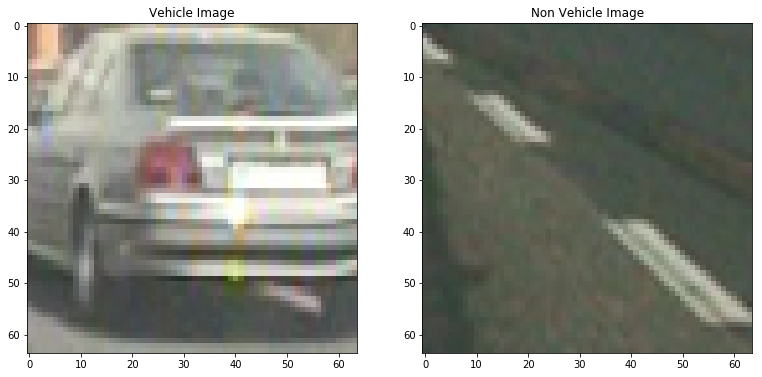

In [3]:
index = 500

vehicle_image = vehicles_images[index]
non_vehicle_image = non_vehicles_images[index]

# Show example test images
fig, axes = plt.subplots(ncols=2, figsize=(13, 10))
axes[0].imshow(vehicle_image)
axes[0].set_title('Vehicle Image')
axes[1].imshow(non_vehicle_image)
axes[1].set_title('Non Vehicle Image')

### Extract HOG Features

In [4]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

import time

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features


# Define a function to compute color histogram features  
def color_hist(image, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and/or visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features  

In [6]:
# Define a function to extract features from an image
def extract_features(image, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                    spatial_feat=True, hist_feat=True, hog_feat=True):   
    
    # Empty list to receive features
    img_features = []
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)       
        
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_feat == True:  
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    # Apply bin_spatial() to get spatial color features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, spatial_size)
        img_features.append(spatial_features)

    # Apply color_hist() to get color histogram features
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        img_features.append(hist_features)
    
    # Append the new feature vector to the features list
    features = []
    
    features = np.concatenate(img_features)
    
    # Return list of feature vectors
    return features


# Define a function to extract features from a list of images
def extract_images_features(images, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2 ):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in images:
        image_features = extract_features(image, cspace=cspace, spatial_size=spatial_size,
                    hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block )

        features.append(image_features)

    # Return list of feature vectors
    return features

/Users/sebastian/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


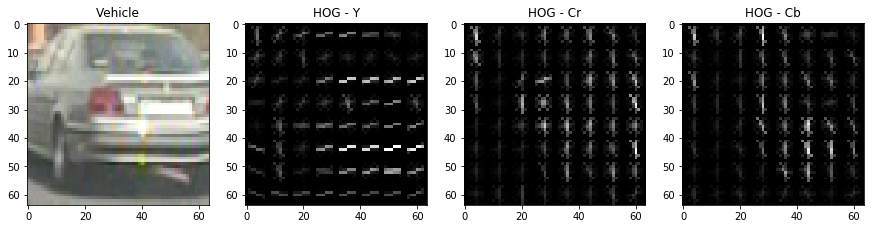

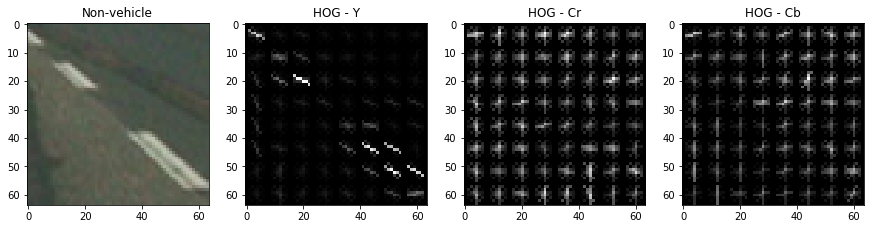

In [7]:
# Calculate HOG on an image and the YCrCb color space and show them
def show_hog_image(image, title):
    image_cspaced = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    orient=9
    pix_per_cell=8
    cell_per_block=2
    vis=True
    feature_vec=True
        
    _, hog_y = get_hog_features(image_cspaced[:,:,0], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=2, vis=vis, feature_vec=feature_vec)
    
    _, hog_Cr = get_hog_features(image_cspaced[:,:,1], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=2, vis=vis, feature_vec=feature_vec)
    
    _, hog_Cb = get_hog_features(image_cspaced[:,:,2], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=2, vis=vis, feature_vec=feature_vec)

    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(image)
    axes[0].set_title(title)
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y')
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')

show_hog_image(vehicle_image, 'Vehicle')
show_hog_image(non_vehicle_image, 'Non-vehicle')

### Train linear SVM classifier using selected HOG features

In [8]:
# Using YCrCb colorspace (Tested with different color spaces YCrCb, RGB, HSV, LUV, HLS, YUV)
cspace='YCrCb' # YCrCb had best test accuracy

vehicle_features = extract_images_features(vehicles_images, cspace=cspace)
print("Extrating feature vectors from vehicle images was successfully")

non_vehicle_features = extract_images_features(non_vehicles_images, cspace=cspace)
print("Extrating feature vectors from non vehicles images was successfully")

/Users/sebastian/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extrating feature vectors from vehicle images was successfully
Extrating feature vectors from non vehicles images was successfully


In [9]:
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC(C=1.0)

# Add a calibrated classifier to get probabilities
clf = CalibratedClassifierCV(svc)

# Check the training time for the Linear SVC Classifier
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print('Training Linear SVC Classifier was successfully in sec', round(t2-t, 4)) 

# Check the score of the SVC
print('Train Accuracy of Linear SVC Classifier =', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of Linear SVC Classifier =', round(clf.score(X_test, y_test), 4))

Training Linear SVC Classifier was successfully in sec 28.5051
Train Accuracy of Linear SVC Classifier = 1.0
Test Accuracy of Linear SVC Classifier = 0.9958


In [10]:
# Check the prediction time for a single image sample
t=time.time()
prediction = clf.predict(X_test[index].reshape(1, -1))
prob = clf.predict_proba(X_test[index].reshape(1, -1))
t2 = time.time()
print('Time to predict an image sample with Linear SVC Classifier in sec', round(t2-t, 4))

print("Prediction {}".format(prediction))
print("Prob {}".format(prob))

Time to predict an image sample with Linear SVC Classifier in sec 0.0044
Prediction [0.]
Prob [[0.99855174 0.00144826]]


In [11]:
# Save model & scaler
joblib.dump(svc, './models/LinearSVC.pkl')
joblib.dump(clf, './models/CalibratedClassifierCV.pkl')
joblib.dump(X_scaler, './models/XScaler.pkl')
print("Saving model and scaler was successfully")

Saving model and scaler was successfully


## Sliding Window Search

In [12]:
# Basic functions provided on Udacity's course to creating windows and drawing boxes on an image.

# Define a function for drawing bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image, start and stop positions in both x and y, window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Using the Classifier on Test Images

In [13]:
test_images = load_images('./test_images/*.jpg')

Loading test images from ./test_images/*.jpg


In [19]:
# Returns a new image with the vehicle bounding boxes.
# y_start_stop : Contains the Y axis range to find the cars.
# xy_window : Contains the windows size.
# xy_overlap : Contains the windows overlap percent.
    
def classify_vehicle(image):
    vehicle_windows = []
    
    # Run different size sliding windows over image
    windows_64 = slide_window(image, x_start_stop=[300, 1250], y_start_stop=[350, 500], xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    # print(len(windows_64))
    
    windows_128 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 680], xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    # print(len(windows_128))
    
    windows_256 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], xy_window=(256, 256), xy_overlap=(0.85, 0.85))
    # print(len(windows_256))
    
    windows = windows_64 + windows_128 + windows_256
    # print(len(windows))
    
    for window in windows:
        image_window = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        image_feature = extract_features(image_window, cspace='YCrCb')
        
        # Scale extracted features to be fed to classifier
        scaled_X = X_scaler.transform(image_feature.reshape(1, -1))
        # Predict using classifier
        prediction = clf.predict(scaled_X)

        # If positive (prediction == 1) then save the window
        if prediction == 1:
            vehicle_windows.append(window)
            #print ('vehicle found with probability', clf.predict_proba(scaled_X))   
    return vehicle_windows

#def draw_vehicle_boxes(image, windows):
#    return draw_boxes(np.copy(image), windows)

In [20]:
vehicle_test_images = list(map(lambda img: draw_boxes(np.copy(img), classify_vehicle(img)), test_images))

990
610
54
1654


/Users/sebastian/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


990
610
54
1654
990
610
54
1654
990
610
54
1654
990
610
54
1654
990
610
54
1654


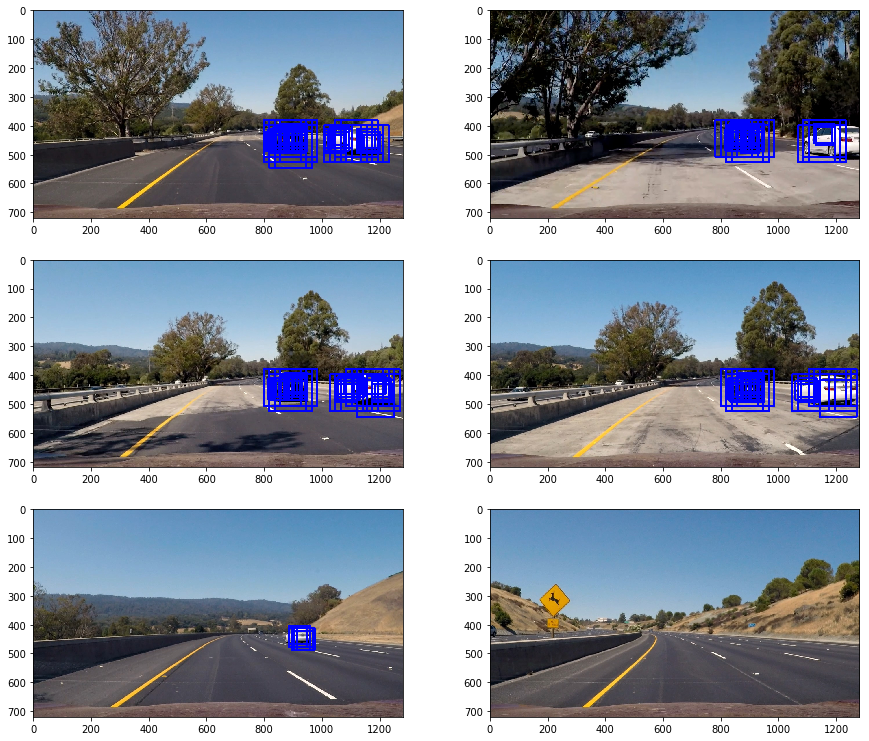

In [21]:
def show_images(images, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    length = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < length:
            image = images[index]
            ax.imshow(image)
            
show_images(vehicle_test_images)